In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
from utils.UCCSD_ansatz import Get_UCCSD_ia_terms, Get_UCCSD_ijab_terms, Fermi_ops_to_qubit_ops

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

import cirq

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
#atom_3 = 'O'
basis = 'sto-3g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
#coordinate_3 = (0.0, bond_len, 0.0)

geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]#, (atom_3, coordinate_3)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_op = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_op)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (-1.5419759528969692+0j) [] +
(-0.03640948355953764+0j) [X0 X1 Y2 Y3] +
(0.03640948355953764+0j) [X0 Y1 Y2 X3] +
(0.05246557037552685+0j) [X0 Z1 X2] +
(-0.009234661837974558+0j) [X0 Z1 X2 Z3] +
(0.04322997146404521+0j) [X0 X2] +
(0.03640948355953764+0j) [Y0 X1 X2 Y3] +
(-0.03640948355953764+0j) [Y0 Y1 X2 X3] +
(0.05246557037552685+0j) [Y0 Z1 Y2] +
(-0.009234661837974558+0j) [Y0 Z1 Y2 Z3] +
(0.04322997146404521+0j) [Y0 Y2] +
(0.7589136134172096+0j) [Z0] +
(0.04322997146404521+0j) [Z0 X1 Z2 X3] +
(0.04322997146404521+0j) [Z0 Y1 Z2 Y3] +
(0.23578727153769516+0j) [Z0 Z1] +
(0.12887693985157755+0j) [Z0 Z2] +
(0.1652864234111152+0j) [Z0 Z3] +
(0.05246557037552685+0j) [X1 Z2 X3] +
(-0.009234661837974558+0j) [X1 X3] +
(0.05246557037552685+0j) [Y1 Z2 Y3] +
(-0.009234661837974558+0j) [Y1 Y3] +
(0.7589136134172096+0j) [Z1] +
(0.1652864234111152+0j) [Z1 Z2] +
(0.12887693985157755+0j) [Z1 Z3] +
(0.19140054473500764+0j) [Z2] +
(0.18815905542064587+0j) [Z2 Z3] +
(0.19140054473500764+0j

In [3]:
#ia, theta1 = Get_UCCSD_ia_terms(calculated_molecule.n_electrons, calculated_molecule.n_orbitals)
#ijab, theta2 = Get_UCCSD_ijab_terms(calculated_molecule.n_electrons, calculated_molecule.n_orbitals)

In [4]:
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 3, criterion='weight')[-1]

In [5]:
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits)
A = circs.A
A

{'IZXI': -0.07087650179757096, 'ZIZI': 0.9974850983813939}

In [6]:
circs.run_cs_vqe(ucc, max_sim_q = 12, iters=3)

*** specified maximum number of qubits to simulate exceeds total ***
*Performing 2-qubit CS-VQE over qubit positions 1 + ancilla


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Expectation value of A: 0.9999999999999997
Reached target energy in fewer iterations than specified
*Performing 3-qubit CS-VQE over qubit positions 3, 1 + ancilla
Expectation value of A: 0.9999999999999987
*Performing 3-qubit CS-VQE over qubit positions 3, 1 + ancilla
Expectation value of A: 0.9999999999999987
*Performing 3-qubit CS-VQE over qubit positions 3, 1 + ancilla
Expectation value of A: 0.9999999999999987
*Performing 4-qubit CS-VQE over qubit positions 3, 2, 1 + ancilla
Expectation value of A: 0.999999999999997
Reached target energy in fewer iterations than specified
*Performing 5-qubit CS-VQE over qubit positions 3, 2, 1, 0 + ancilla
Expectation value of A: 0.9999999999999967
*Performing 5-qubit CS-VQE over qubit positions 3, 2, 1, 0 + ancilla
Expectation value of A: 0.999999999999998
Reached target energy in fewer iterations than specified


In [7]:
cs_vqe_results = circs.cs_vqe_results

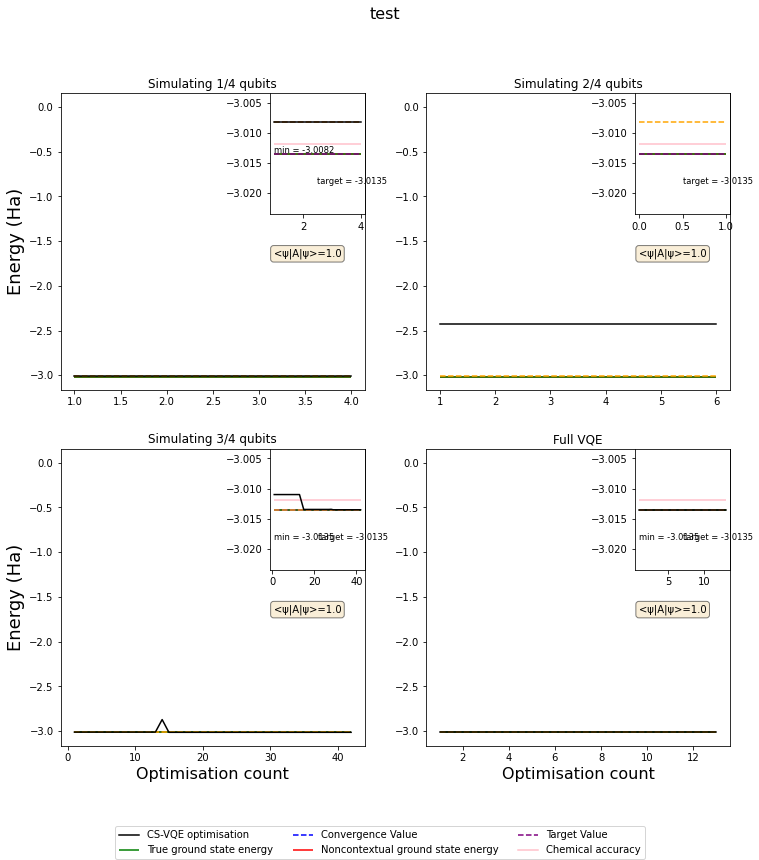

In [8]:
fig = plot.plot_cs_vqe_convergence(data=cs_vqe_results, title='test')

In [9]:
#import json 

#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
     
#with open("data/LiH_STO-3G_singlet_UCCSD_CS-VQE_convergence_with_ground_state_projection.json", "w") as outfile: 
#    json.dump(data, outfile)

In [10]:
circs.order

[2, 0, 1, 3]

In [11]:
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
generators = list((mol.generators()[0]).keys())
initial_state = mol.init_state()
results={}
shots=10
c_order = [0,1,2,3,4,5]

eig_proj = la.eigenstate_projector(A, num_qubits)
nan_check = []

for index in range(num_qubits):
    removed_index = c_order[0:index]#list(range(index))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

    new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)

    results[index] = {}
    results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

    expectations = []
    for r in range(shots):
        rand_vec = la.random_complex_vector(2**num_qubits)
        psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
        expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
        expectations.append(expect_noncon)
    #print(expectations)
    nc_value = (sum(expectations)/shots).real
    results[index]['+1eig'] = nc_value
    nan_check.append(nc_value)

results

[] []
['ZIII'] [0]
['IZII', 'ZIII'] [1, 0]
['IIIZ', 'IZII', 'ZIII'] [3, 1, 0]


{0: {'exact': -3.0134857192955504, '+1eig': -3.0134857192955558},
 1: {'exact': -2.5265073501206285, '+1eig': -2.511706495710962},
 2: {'exact': -1.7767278261670678, '+1eig': -1.7300609068611328},
 3: {'exact': -1.7381977635033339, '+1eig': -1.5371998959132047}}

[(-3.0134857192955504, -2.5265073501206285, -1.7767278261670678, -1.7381977635033339), (-3.0134857192955558, -2.511706495710962, -1.7300609068611328, -1.5371998959132047)]


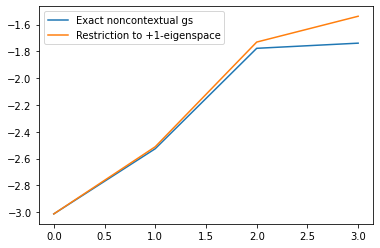

In [12]:
X=range(num_qubits)
values = list(zip(*[list(results[i].values()) for i in X]))
print(values)
Y1=values[0]
Y2=values[1]
#axs[grid].set_title(str(h))
plt.plot(X, Y1, label='Exact noncontextual gs')
plt.plot(X, Y2, label='Restriction to +1-eigenspace')
plt.legend()

In [13]:
#fig.savefig("plots/HeH+-CS-VQE-uccsd_ansatz.png", dpi=300)

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


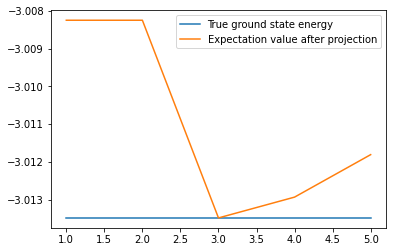

In [14]:
circs.ancilla = False
X = list(range(1, 6))
Y_true = []
Y_proj = []
A = circs.A

for n_q in X:
    ham_red = circs.ham_reduced[n_q-1]
    ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
    gs_red = get_ground_state(get_sparse_operator(ham_red_q, n_q).toarray())
    Y_true.append(gs_red[0])
    
    A_red = circs.reduce_anz_terms(A, n_q)
    eig_proj = la.eigenstate_projector(A_red, n_q)
    psi = gs_red[1]
    psi_proj = la.apply_projections(psi, [eig_proj])
    gs_proj = la.expectation(ham_red, psi_proj, n_q)
    Y_proj.append(gs_proj)
    
plt.plot(X, Y_true, label = 'True ground state energy')
plt.plot(X, Y_proj, label = 'Expectation value after projection')
plt.legend()

In [15]:
rots = circs.all_rotations
print(rots)
rots.reverse()
c_tools.rotate_operator(rots, A)

AttributeError: 'cs_vqe_circuit' object has no attribute 'all_rotations'

In [ ]:
circs.G

In [ ]:
P1, P2 = A.keys()
r1 = A[P1]
r2 = A[P2]
rot = c_tools.pauli_mult(P1, P2)
t = np.arctan(r1/r2)
single_A = c_tools.rotate_operator([[t*(rot[1]*1j).real, rot[0]]], A)

In [ ]:
Z_indices = [g.find('Z') for g in circs.G]

In [ ]:
single_A_indices = [i for i, p in enumerate(list(single_A.keys())[0]) if p == 'Z']

In [ ]:
ind_Z = [i for i in single_A_indices if i not in Z_indices]

In [ ]:
ind_Z

In [ ]:
diag_A = []
for i in ind_Z:    
    blank_op = ['I' for i in range(num_qubits)]
    blank_op[i] = 'Y'
    rot = ''.join(blank_op)
    diag_A.append(['pi/2', rot])
    rotated = c_tools.pauli_mult(rot, list(single_A.keys())[0])[0]
    print(rotated)
    blank_op = ['I' for i in range(num_qubits)]
    for j in single_A_indices:
        if rotated[j]=='Z':
            blank_op[j] = 'Z'
        elif rotated[j] == 'X':
            blank_op[j] = 'Y'
    rot = ''.join(blank_op)
    diag_A.append(['pi/2', rot])

In [ ]:
c_tools.pauli_mult(rot_G, list(single_A.keys())[0])

In [ ]:
A_proj = np.matrix(la.eigenstate_projector(circs.A, num_qubits))
A_proj.trace()